In [2]:
# Standard notebook setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
import datetime as dt
import os
import tempfile

import requests


def combine_dispatch_spreadsheets():
    """
    Return a dataframe containing all available call data
    """
    # Accumulate all the raw call data spreadsheets into one dataframe.
    # No public download link for these spreadsheet files yet.
    df = None
    for year in range(2008, 2018+1):
        xlsx_filename = os.path.join("data/dispatch", "{}.xlsx".format(year))
        xlsx = pd.ExcelFile(xlsx_filename)
        sheet_name = xlsx.sheet_names[0]
        if df is None:
            df = xlsx.parse(sheet_name)
        else:
            df = df.append(xlsx.parse(sheet_name), ignore_index=True, sort=False)
    return df


def convert_coordinates(df):
    """
    The "I Map X" and "I Map Y" columns are NC-3200 State Plane Coordinates, in feet
    (US survey feet I presume.)
    Add incident_lat and incident_lon columns for latitude and longitude, respectively.
    Use the "NGS Coordinate Conversion and Transformation Tool (NCAT)" to convert the
    coordinates.
    """
    pass  # work-in-progress

In [4]:
# Load all the raw dispatch data from CSV if it exists.
# Otherwise, create it by combining all of the Excel files.
filename = "data/dispatch/raw-dispatch-2008-2018.csv"
column_names = ['Event Number', 'Date', 'Address', 'City', 'Beat',
       'Incident Type', 'I Map X', 'I Map Y', 'Unit ID', 'Dispatch Time',
       'Arrive Time']

if not os.path.isfile(filename):
    df = combine_dispatch_spreadsheets()
    df.to_csv(filename, header=column_names, index=False)

df = pd.read_csv(filename, parse_dates=['Date', 'Dispatch Time', 'Arrive Time'])


In [42]:
df.head(10)

,Event Number,Date,Address,City,Beat,Incident Type,I Map X,I Map Y,Unit ID,Dispatch Time,Arrive Time
0,FFD080101000002,2008-01-01 00:36:52,S MAIN ST&E YOUNG ST,RO,RV1I,FBD,2160648.0,791409.0,RVT1,2008-01-01 00:37:51.030,2008-01-01 00:39:58.830
1,FFD080101000004,2008-01-01 01:32:28,4825 RECONCILIATION DR,WCRA,FF3C,FBD,2085345.0,691203.0,FFC20,2008-01-01 01:34:42.930,2008-01-01 01:37:37.110
2,FFD080101000006,2008-01-01 02:05:35,I 40 EB&WADE AVE,WCCA,WW0P,F50I,2075875.0,753690.0,WWR295,2008-01-01 02:06:39.650,NaT
3,FFD080101000006,2008-01-01 02:05:35,I 40 EB&WADE AVE,WCCA,WW0P,F50I,2075875.0,753690.0,WWE191,2008-01-01 02:06:39.500,2008-01-01 02:10:56.480
4,FFD080101000006,2008-01-01 02:05:35,I 40 EB&WADE AVE,WCCA,WW0P,F50I,2075875.0,753690.0,CFE1,2008-01-01 02:06:39.540,NaT
5,FFD080101000006,2008-01-01 02:05:35,I 40 EB&WADE AVE,WCCA,WW0P,F50I,2075875.0,753690.0,WWC190,2008-01-01 02:06:39.700,NaT
6,FRF080101000014,2008-01-01 02:07:47,4011 CAPITAL BLVD,RA,F22Z,F102,2123731.0,759202.0,NHE2,2008-01-01 02:11:49.640,2008-01-01 02:16:16.160
7,FFD080101000008,2008-01-01 03:03:01,537 N TAYLOR ST,WF,WF0E,F102,2146960.0,813695.0,WFE61,2008-01-01 03:03:52.760,2008-01-01 03:08:56.430
8,FFD080101000011,2008-01-01 04:23:11,100 JOHNSTON CO WAY,JC,JC01,FSTRUC,2115290.0,670718.0,FJC911,2008-01-01 04:23:31.190,NaT
9,FFD080101000011,2008-01-01 04:23:11,100 JOHNSTON CO WAY,JC,JC01,FSTRUC,2115290.0,670718.0,GFL1,2008-01-01 04:23:31.260,NaT


In [99]:
unit_ids = sorted(set(df['Unit ID']))
print(len(unit_ids), "unit IDs in call records.")
with open("t.txt", "w") as f:
    for i in unit_ids:
        print(i, file=f)

unit_dispatch_times = pd.DataFrame.from_dict({'Dispatch Time': df['Dispatch Time']})
unit_dispatch_times.index = df['Unit ID']
unit_dispatch_counts = unit_dispatch_times.groupby(level=0).count()
unit_dispatch_counts.sort_values('Dispatch Time', ascending=False, inplace=True)
n = 25
print("Top", n, "utilized units:")
display(unit_dispatch_counts.head(n))
top_n_total = sum(unit_dispatch_counts['Dispatch Time'].head(n))
print("Accounting for", top_n_total, "of", len(df), "dispatches, or", 100*(top_n_total/len(df)), "percent.")
print(len(unit_dispatch_counts[ unit_dispatch_counts['Dispatch Time'] == 1]), "units were only dispatched once.")

512 unit IDs in call records.
Top 25 utilized units:


,Dispatch Time
Unit ID,
GFE3,19712
GFE1,19332
WFE1,14034
GFBATT1,11613
NHE1,11174
GFE2,10023
WEB114,8950
GFE4,8646
WFL1,8029


Accounting for 206615 of 407353 dispatches, or 50.721364516770464 percent.
44 units were only dispatched once.


In [7]:
# All dispatches in 2015
y2015 = dt.datetime(2015, 1, 1)
y2016 = dt.datetime(2016, 1, 1)
df_2015 = df[(df["Dispatch Time"] >= y2015) & (df["Dispatch Time"] < y2016)]
print("Number of dispatches in Y2015:", len(df_2015))
# Count unique incident IDs in 2015
print("Number of unique incident IDs in Y2015:", len(set(df_2015["Event Number"])))

Number of dispatches in Y2015: 38103
Number of unique incident IDs in Y2015: 23285


In [38]:
g = df.groupby('Event Number')
call_events = g['Dispatch Time'].min()
df2 = pd.DataFrame({"Event Number": call_events.index}, index=call_events)
call_events_monthly = df2.groupby(pd.Grouper(freq='M')).count()

<IPython.core.display.Javascript object>


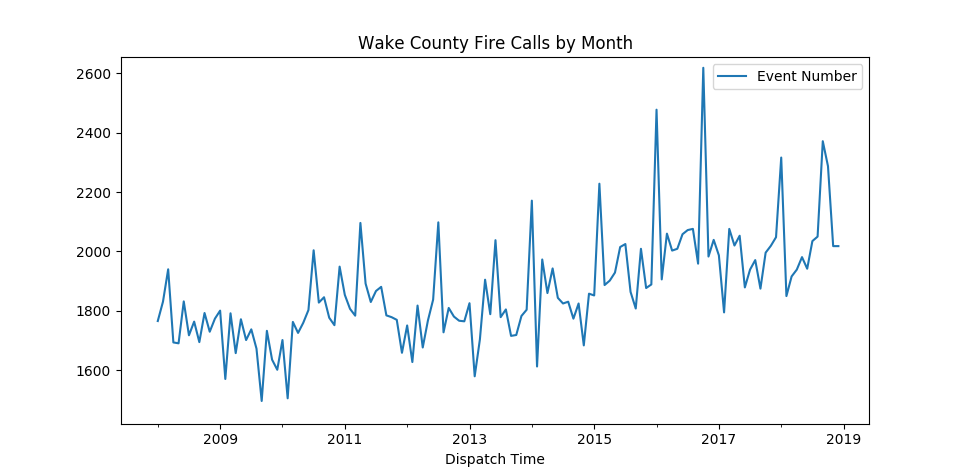

In [40]:
%matplotlib notebook
title = "Wake County Fire Calls by Month"
p = call_events_monthly.plot(title=title)